In [3]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 2.5MB/s 
     |████████████████████████████████| 5.6MB 11.6MB/s 
     |████████████████████████████████| 1.6MB 34.9MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [5]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

x_train, x_test= x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [6]:
def filter_36(x, y):
  keep=(y == 3) | (y == 6)
  x, y=x[keep], y[keep]
  y = y == 3
  return x, y

In [7]:
x_train, y_train= filter_36(x_train, y_train)
x_test, y_test= filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(y_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


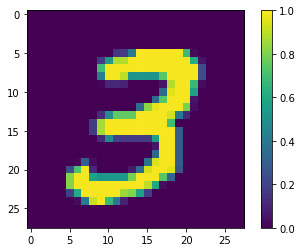

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [9]:
x_train_small=tf.image.resize(x_train, (4, 4)).numpy()
x_test_small=tf.image.resize(x_test, (4, 4)).numpy()

True


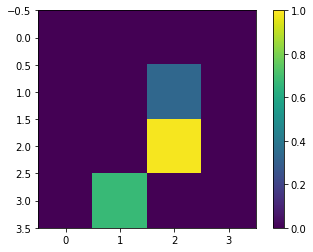

In [10]:
print(y_train[0])

plt.imshow(x_train_small[0, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

In [11]:
def remove_contradicting(xs, ys):
  mapping=collections.defaultdict(set)
  for x, y in zip(xs, ys):
    mapping[tuple(x.flatten())].add(y)

  new_x=[]
  new_y=[]
  for x, y in zip(xs, ys):
    labels=mapping[tuple(x.flatten())]
    if len(labels) == 1:
      new_x.append(x)
      new_y.append(list(labels)[0])
    else:
      pass
  
  num_3=sum(1 for value in mapping.values() if True in value)
  num_6=sum(1 for value in mapping.values() if False in value)
  num_both=sum(1 for value in mapping.values() if len(value) == 2)

  print("Number of unique images:", len(mapping.values()))
  print("Number of 3s:", num_3)
  print("Number of 6s:", num_6)
  print("Number of contradictory images:", num_both)
  print()
  print("Initial number of examples:", len(xs))
  print("Remaining non-controdictory examples:", len(new_x))

  return np.array(new_x), np.array(new_y)

In [12]:
x_train_nocon, y_train_nocon= remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s: 4961
Number of 6s: 5475
Number of contradictory images: 49

Initial number of examples: 12049
Remaining non-controdictory examples: 11520


In [13]:
THRESHOLD=0.5

x_train_bin=np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin=np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [14]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of 3s: 124
Number of 6s: 113
Number of contradictory images: 44

Initial number of examples: 11520
Remaining non-controdictory examples: 3731


In [15]:
def convert_to_circuit(image):
  """Encode truncated classical image into quantum datapoint."""
  values=np.ndarray.flatten(image)
  qubits=cirq.GridQubit.rect(4, 4)
  circuit=cirq.Circuit()
  for i, value in enumerate(values):
    if value:
      circuit.append(cirq.X(qubits[i]))
  return circuit

x_train_circ=[convert_to_circuit(x) for x in x_train_bin]
x_test_circ=[convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


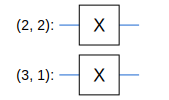

In [16]:
SVGCircuit(x_train_circ[0])

In [17]:
bin_img=x_train_bin[0, :, :, 0]
indices=np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [19]:
x_train_tfcirc=tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc=tfq.convert_to_tensor(x_test_circ)

In [23]:
class CircuitLayerBuilder():
  def __init__(self, data_qubits, readout):
    self.data_qubits=data_qubits
    self.readout=readout

  def add_layer(self, circuit, gate, prefix):
    for i, qubit in enumerate(self.data_qubits):
      symbol=sympy.Symbol(prefix + '-' + str(i))
      circuit.append(gate(qubit, self.readout)** symbol )

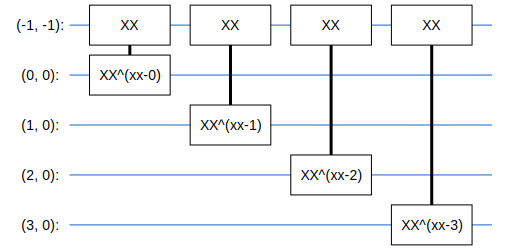

In [24]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [26]:
def create_quantum_model():
  """Create a QNN model circuit and readout operation to go along with it."""
  data_qubits=cirq.GridQubit.rect(4, 4)
  readout=cirq.GridQubit(-1, -1)
  circuit=cirq.Circuit()

  circuit.append(cirq.X(readout))
  circuit.append(cirq.H(readout))

  builder=CircuitLayerBuilder(
      data_qubits=data_qubits,
      readout=readout)
  
  builder.add_layer(circuit, cirq.XX, 'xx1')
  builder.add_layer(circuit, cirq.ZZ, 'zz1')

  circuit.append(cirq.H(readout))

  return circuit, cirq.Z(readout)

In [28]:
model_circuit, model_readout= create_quantum_model()

In [30]:
model=tf.keras.Sequential([
                           tf.keras.layers.Input(shape=(), dtype=tf.string),
                           tfq.layers.PQC(model_circuit, model_readout),
])

In [31]:
y_train_hinge=2.0*y_train_nocon-1.0
y_test_hinge=2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [35]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy]
)

In [37]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
EPOCHS=3
BATCH_SIZE=32

NUM_EXAMPLES=len(x_train_tfcirc)

In [39]:
x_train_tfcirc_sub=x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub=y_train_hinge[:NUM_EXAMPLES]

In [40]:
qnn_history=model.fit(
    x_train_tfcirc_sub, y_train_hinge_sub,
    batch_size=32,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results=model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
360/360 [==============================] - 639s 2s/step - loss: 0.6797 - hinge_accuracy: 0.7357 - val_loss: 0.3663 - val_hinge_accuracy: 0.8135
Epoch 2/3
360/360 [==============================] - 646s 2s/step - loss: 0.3595 - hinge_accuracy: 0.8167 - val_loss: 0.3497 - val_hinge_accuracy: 0.8226
Epoch 3/3
62/62 [==============================] - 16s 258ms/step - loss: 0.3419 - hinge_accuracy: 0.8246


In [42]:
def create_classical_model():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(1))
  return model

model=create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [43]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))
cnn_results=model.evaluate(x_test, y_test)

62/62 [==============================] - 1s 21ms/step - loss: 0.0045 - accuracy: 0.9990


In [44]:
def create_fair_classical_model():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(4, 4, 1)))
  model.add(tf.keras.layers.Dense(2, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  return model

model=create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(x_train_bin,
          y_train_nocon,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))
fair_nn_results=model.evaluate(x_test_bin, y_test)

Epoch 1/20
360/360 - 0s - loss: 0.5794 - accuracy: 0.7754 - val_loss: 0.5109 - val_accuracy: 0.8110
Epoch 2/20
360/360 - 0s - loss: 0.4568 - accuracy: 0.8390 - val_loss: 0.4355 - val_accuracy: 0.8227
Epoch 3/20
360/360 - 0s - loss: 0.3883 - accuracy: 0.8541 - val_loss: 0.3759 - val_accuracy: 0.8293
Epoch 4/20
360/360 - 0s - loss: 0.3349 - accuracy: 0.8613 - val_loss: 0.3315 - val_accuracy: 0.8328
Epoch 5/20
360/360 - 0s - loss: 0.2979 - accuracy: 0.8775 - val_loss: 0.3003 - val_accuracy: 0.8714
Epoch 6/20
360/360 - 0s - loss: 0.2726 - accuracy: 0.8874 - val_loss: 0.2780 - val_accuracy: 0.8714
Epoch 7/20
360/360 - 0s - loss: 0.2554 - accuracy: 0.8878 - val_loss: 0.2634 - val_accuracy: 0.8714
Epoch 8/20
360/360 - 0s - loss: 0.2434 - accuracy: 0.8874 - val_loss: 0.2529 - val_accuracy: 0.8730
Epoch 9/20
360/360 - 0s - loss: 0.2346 - accuracy: 0.9080 - val_loss: 0.2459 - val_accuracy: 0.9197
Epoch 10/20
360/360 - 0s - loss: 0.2283 - accuracy: 0.9143 - val_loss: 0.2400 - val_accuracy: 0.9197

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


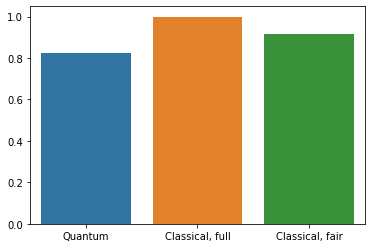

In [47]:
qnn_accuracy=qnn_results[1]
cnn_accuracy=cnn_results[1]
fair_nn_accuracy=fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])